# Comparing systems with and without accretion

# Imports and whatnot

In [1]:
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f4496c6bf40>

In [2]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

import astropy.units as u

from ipywidgets import interact, IntSlider

import seaborn as sns

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [4]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid)

<module 'mesagrid' from '/home/tom/Documents/research/kavli-2023/algol-seismology/notebooks/../mesagrid.py'>

In [342]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L',
                   'center_h1', 'center_he4', 'star_mass']
cpus = 8

pairs = [(3, 0), (3, 0.65), (3.51317, 0), (3, 0.4)]
tracks = [mesagrid.Track(f"../output/mass_transfer_grid/M_{M}-MT_{MT}/",
                       usecols_history=usecols_history,
                       cpus=cpus, parameters=f"M={M}, MT={MT}") for M, MT in pairs]

In [138]:
import astropy.constants as const

In [139]:
def nuclear_time(M):
    return 7.5e9 * M.to(u.Msun).value**(-2.5) * u.yr

def thermal_time(R, M):
    return 2.2e7 * R.to(u.Rsun).value**(-1) * M.to(u.Msun).value**(-1.5) * u.yr

In [140]:
f"Nuclear Timescale: {nuclear_time(3 * u.Msun):1.2e}, Thermal Timescale: {thermal_time(2.2 * u.Rsun, 3 * u.Msun):1.2e}"

'Nuclear Timescale: 4.81e+08 yr, Thermal Timescale: 1.92e+06 yr'

In [302]:
def get_radius(history):
    L = 10**(history["log_L"]).values * u.Lsun
    Teff = 10**(history["log_Teff"]).values * u.K
    return np.sqrt(L / (4 * np.pi * const.sigma_sb * Teff**4)).to(u.Rsun)

In [311]:
tracks[1].history.iloc[42:124]

,model_number,star_age,star_mass,log_Teff,log_L,center_h1,center_he4
42,43,5.040290e+07,3.009785,4.083123,1.962521,0.640208,0.339622
43,44,5.044204e+07,3.019570,4.085413,1.974882,0.640161,0.339670
44,45,5.047335e+07,3.027398,4.086712,1.981458,0.640151,0.339680
45,46,5.050286e+07,3.034775,4.087670,1.986062,0.640203,0.339627
46,47,5.053105e+07,3.041823,4.088443,1.989668,0.640325,0.339504
...,...,...,...,...,...,...,...
119,120,5.225578e+07,3.473006,4.125640,2.189481,0.647125,0.332654
120,121,5.228244e+07,3.479670,4.126182,2.192456,0.647207,0.332572
121,122,5.230912e+07,3.486340,4.126723,2.195424,0.647282,0.332496
122,123,5.233583e+07,3.493017,4.127264,2.198391,0.647360,0.332417


Parsing M=3, MT=0
Parsing M=3, MT=0.65
Parsing M=3.51317, MT=0
Parsing M=3, MT=0.4


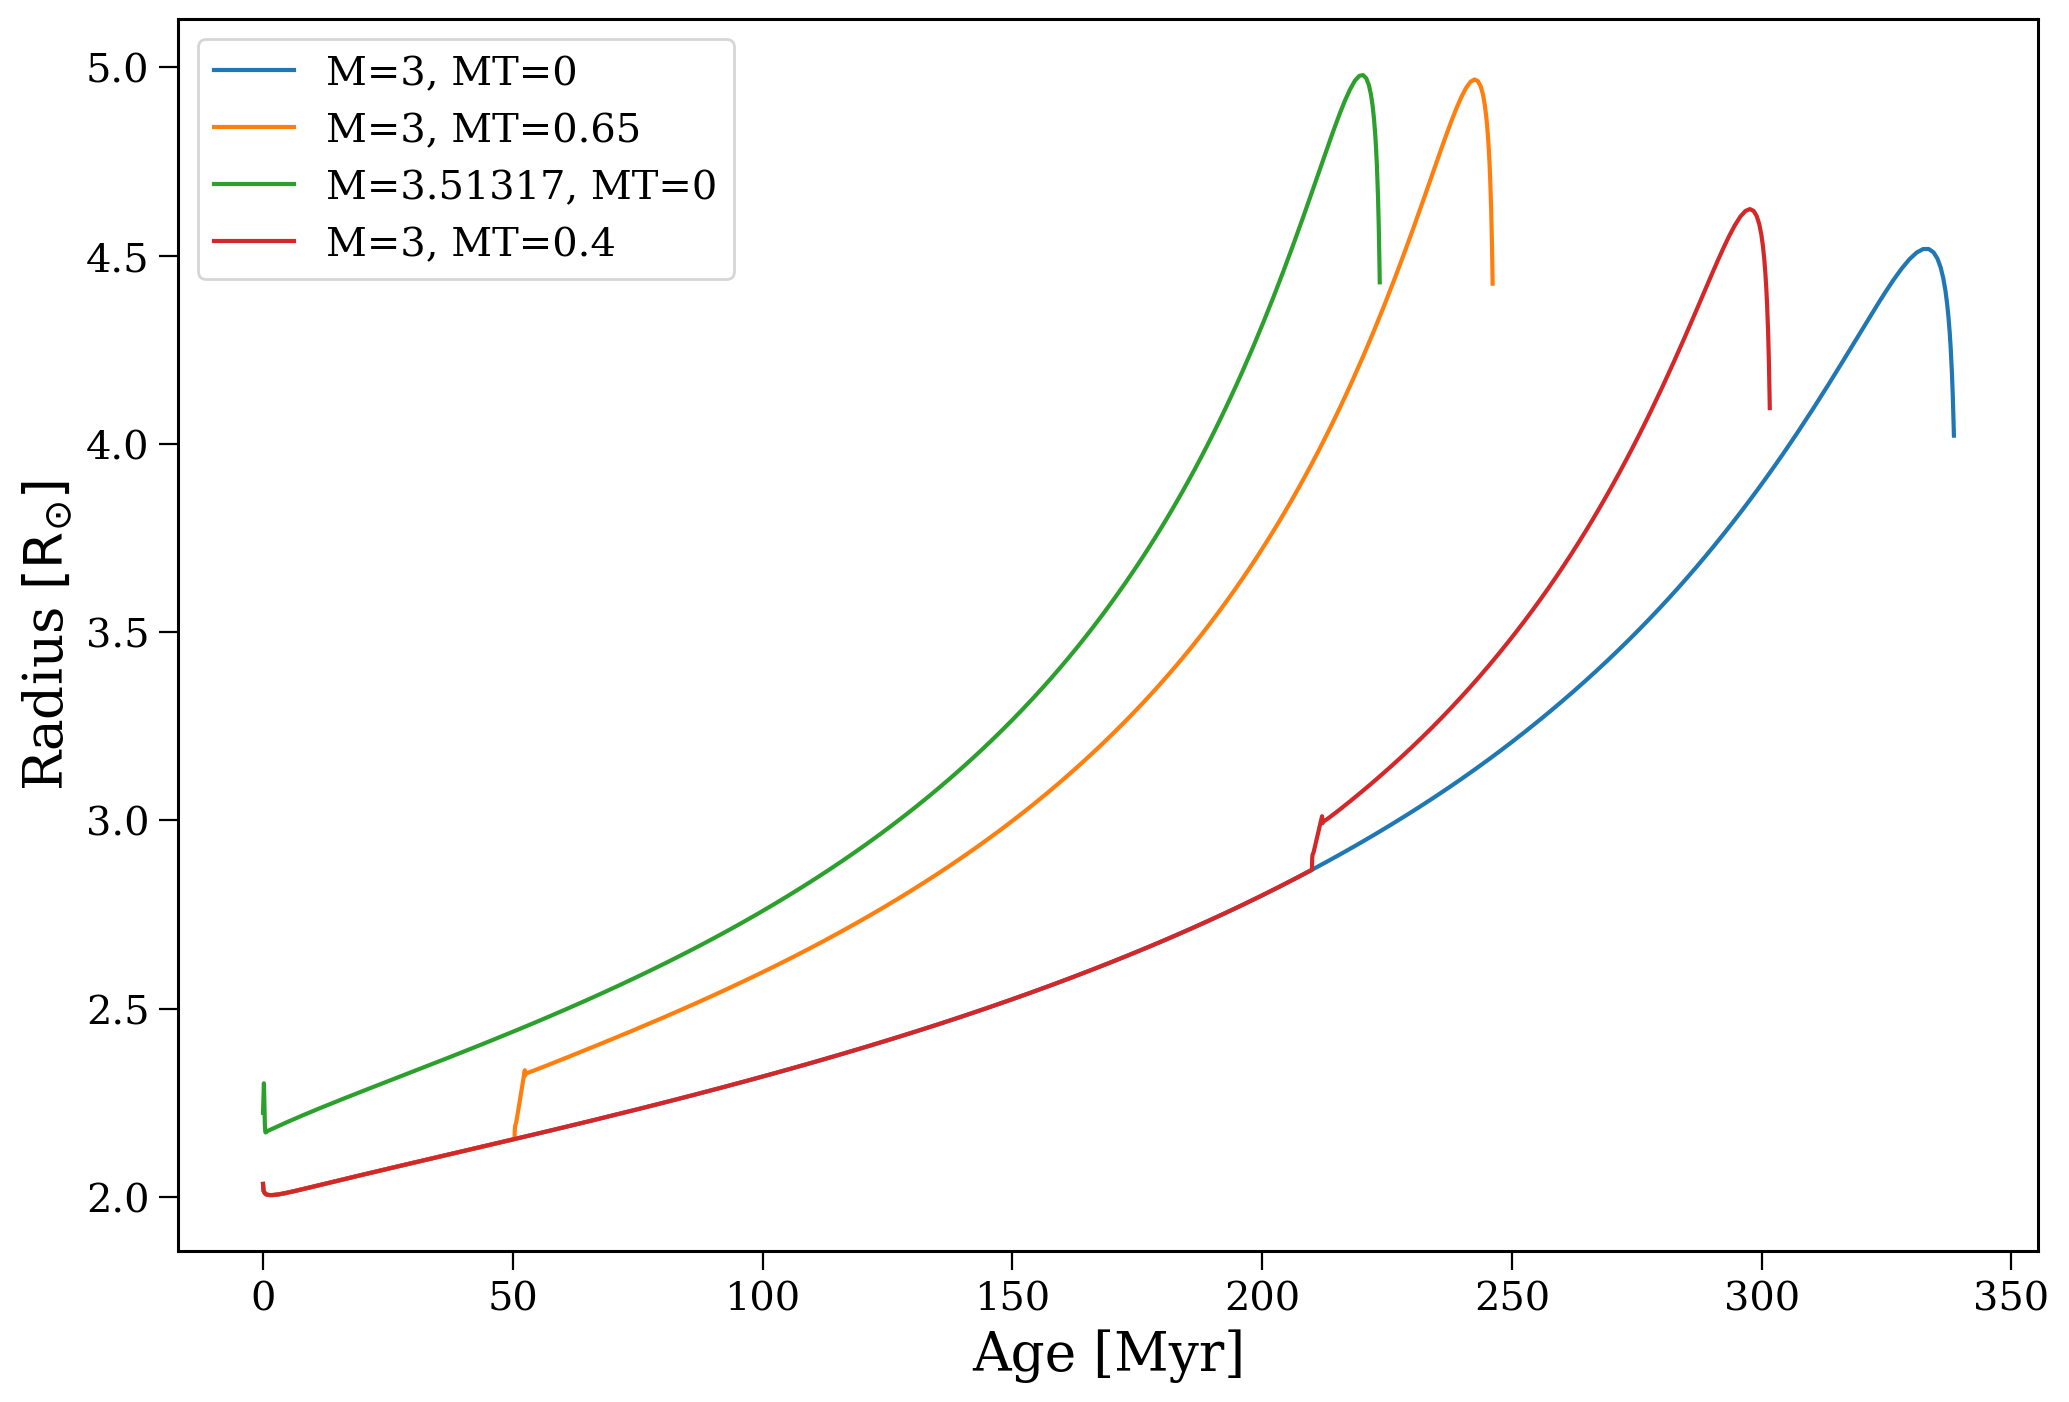

In [343]:
fig, ax = plt.subplots()

for i in range(len(tracks)):
    h = tracks[i].history[tracks[i].history["center_h1"] < tracks[i].history["center_h1"].iloc[0]]
    ax.plot(h["star_age"] / 1e6, get_radius(h), label=tracks[i].parameters)
ax.legend()
ax.set_xlabel("Age [Myr]")
ax.set_ylabel(r"Radius $[\rm R_{\odot}]$")
plt.show()

In [162]:
def simple_hr(track, ylabel=r'Luminosity $\mathbf{\log_{10}(L/L_{\odot})}$',
              cbar_var="center_he4", cbar_label=r"$X_{\rm He, center}$",
              fig=None, ax=None, show=True, add_axes_info=False, plot_line=True, **kwargs):
    new_fig = (fig is None or ax is None)
    if new_fig:
        fig, ax = plt.subplots(figsize=(8,6))
    
    df = track.history
    df = df.loc[df.center_h1 <= df.center_h1.max() - 0.005]
    if 's' not in kwargs:
        kwargs['s'] = 10
    if 'cmap' not in kwargs and cbar_var is not None:
        kwargs['cmap'] = "copper"
    c = df[cbar_var] if cbar_var is not None else None
    
    if plot_line:
        ax.plot(df['log_Teff'], df['log_L'], color="lightgrey", zorder=-1)
    ax.scatter(df['log_Teff'], df['log_L'], c=c, **kwargs)
    
    if new_fig or add_axes_info:
        ax.invert_xaxis()
        ax.set_xlabel(r'Effective temperature $\mathbf{\log_{10}(T_{eff}/K)}$')
        ax.set_ylabel(ylabel)

        if cbar_var is not None:
            inset_ax = ax.inset_axes([0.38, 0.025, 0.6, 0.025])
            fig.colorbar(ax.collections[0], label=cbar_label, cax=inset_ax, orientation="horizontal", location="top")
    
    # plt.tight_layout()
    
    if show:
        plt.show()
        
    return fig, ax

In [145]:
tracks[1].history[tracks[1].history["star_mass"] > 3.0].index[0], tracks[1].history[tracks[1].history["star_mass"] > 3.5].index[0]

(42, 124)

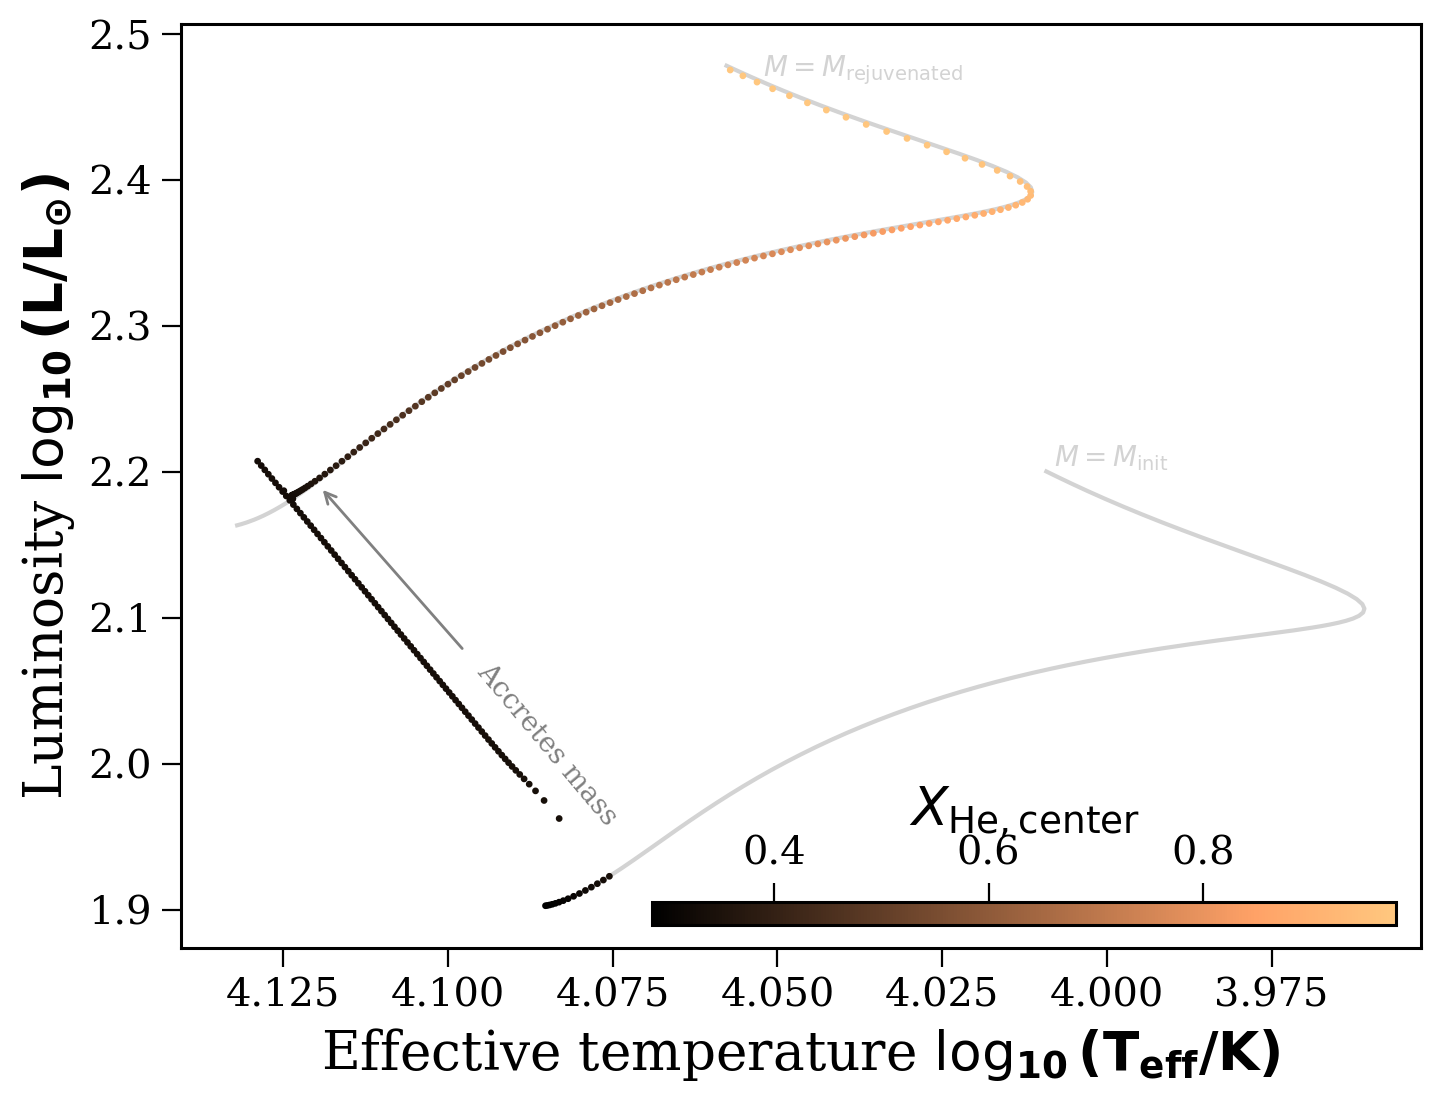

In [200]:
fig, ax = simple_hr(track=tracks[0], show=False, s=0)
fig, ax = simple_hr(track=tracks[1], fig=fig, ax=ax, show=False, plot_line=False, s=2)
fig, ax = simple_hr(track=tracks[2], fig=fig, ax=ax, show=False, s=0)

ax.annotate(r"$M = M_{\rm init}$", xy=(0.75, 0.53), ha="center", va="center",
            xycoords="axes fraction", color="lightgrey")
ax.annotate(r"$M = M_{\rm rejuvenated}$", xy=(0.55, 0.95), ha="center", va="center",
            xycoords="axes fraction", color="lightgrey")

ax.annotate("Accretes mass", xy=(0.1115, 0.5), xytext=(0.295, 0.22), xycoords="axes fraction", rotation=-50,
            arrowprops=dict(arrowstyle="->", color="grey"), color="grey", ha="center", va="center")

plt.show()

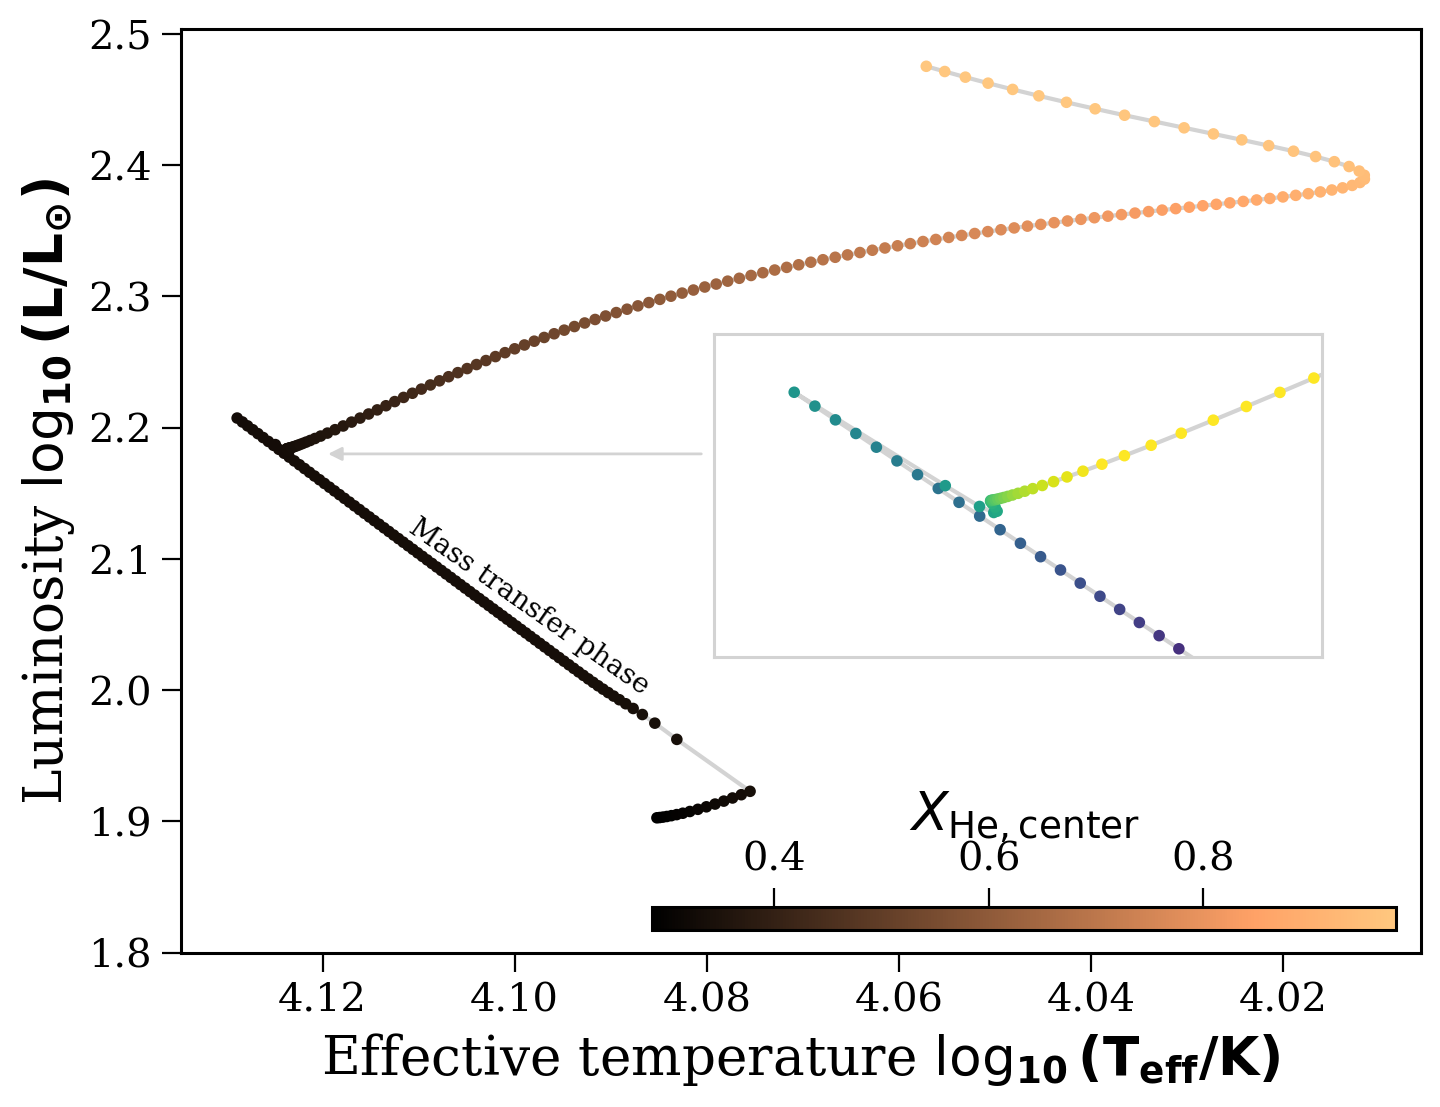

In [157]:
fig, ax = simple_hr(track=tracks[1], show=False)
ax.set_ylim(bottom=1.8)

inset_ax = ax.inset_axes([0.43, 0.32, 0.49, 0.35])
simple_hr(track=tracks[1], fig=fig, ax=inset_ax, show=False, cbar_var="model_number", cmap="viridis", vmin=100, vmax=150)
inset_ax.set_xlim(4.131, 4.115)
inset_ax.set_ylim(2.15, 2.22)
inset_ax.set_xticks([])
inset_ax.set_yticks([])

for spine in inset_ax.spines:
    inset_ax.spines[spine].set_color("lightgrey")

ax.annotate("", xy=(4.12, 2.18), xytext=(4.08, 2.18), arrowprops=dict(arrowstyle="-|>", color="lightgrey"))

ax.annotate("Mass transfer phase", xy=(0.18, 0.28), xycoords="axes fraction", rotation=-35)
plt.show()

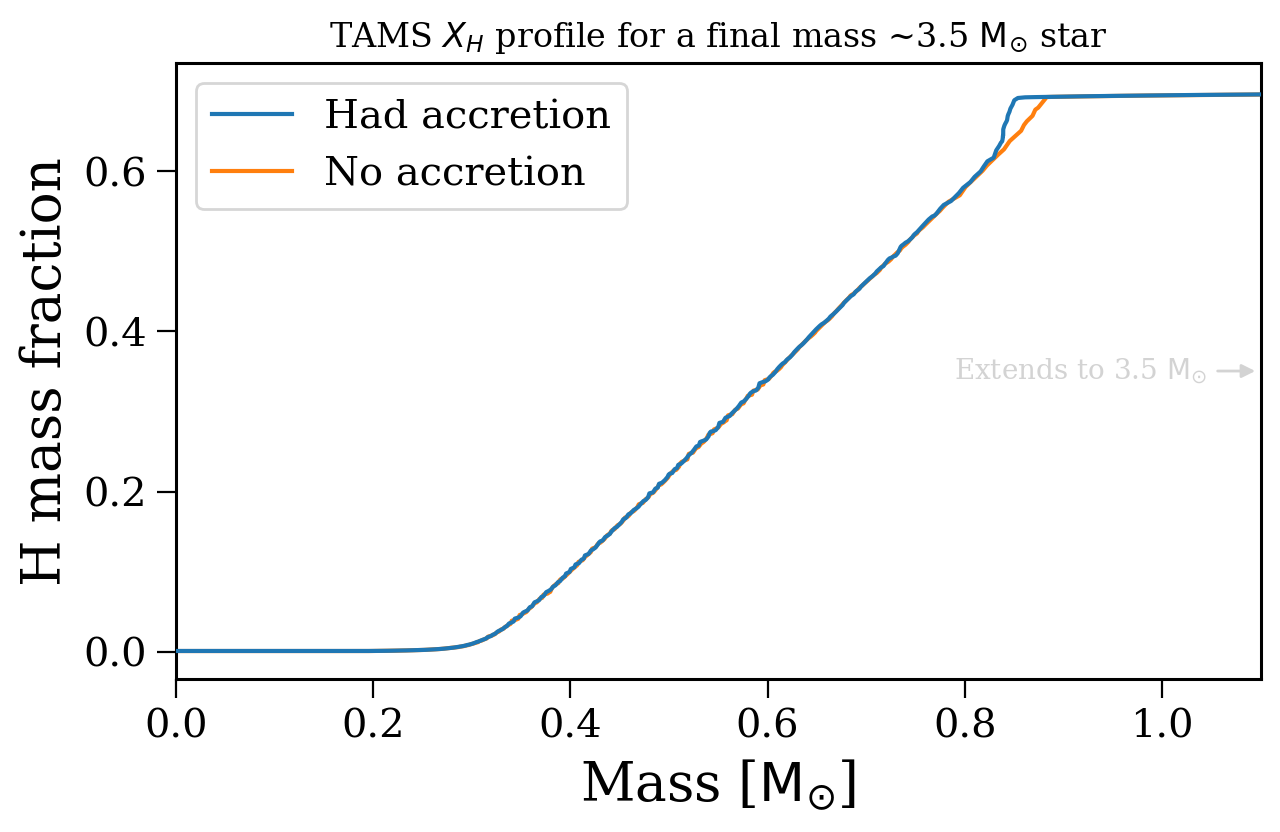

In [238]:
plt.figure(figsize=(7, 4))

plt.plot(tracks[1].profiles[-1]["mass"], tracks[1].profiles[-1]["x_mass_fraction_H"], label="Had accretion", zorder=3)
plt.plot(tracks[2].profiles[-1]["mass"], tracks[2].profiles[-1]["x_mass_fraction_H"], label="No accretion")

plt.legend()

plt.xlabel(r"Mass [$\rm M_{\odot}$]")
plt.ylabel("H mass fraction")

plt.annotate(r"Extends to 3.5 $\rm M_{\odot}$", xy=(1, 0.5), xytext=(0.95, 0.5), xycoords="axes fraction",
             ha="right", va="center", color="lightgrey", arrowprops=dict(arrowstyle="-|>", color="lightgrey"))

plt.xlim(0, 1.1)
plt.title(r"TAMS $X_H$ profile for a final mass ~3.5 $\rm M_{\odot}$ star")

plt.show()

In [253]:
np.abs(tracks[1].history["star_age"] / 1e6 - 150).argmin()

179

In [379]:
def plot_X_H_profile(age, mt_index=1, ref_index=2, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
        
    plt.cla()
    print(round(age, 1))

    acc_mod = np.abs(tracks[mt_index].history["star_age"] / 1e6 - age).argmin()
    non_acc_mod = np.abs(tracks[ref_index].history["star_age"] / 1e6 - age).argmin()

    ax.plot(tracks[mt_index].profiles[acc_mod]["mass"],
            tracks[mt_index].profiles[acc_mod]["x_mass_fraction_H"],
             label="Had accretion", zorder=3)
    ax.plot(tracks[ref_index].profiles[non_acc_mod]["mass"],
            tracks[ref_index].profiles[non_acc_mod]["x_mass_fraction_H"],
             label="No accretion")

    ax.legend(loc="lower right")

    ax.set_xlabel(r"Mass [$\rm M_{\odot}$]")
    ax.set_ylabel("H mass fraction")

    ax.annotate(r"Extends to 3.5 $\rm M_{\odot}$", xy=(1, 0.5), xytext=(0.95, 0.5), xycoords="axes fraction",
                 ha="right", va="center", color="lightgrey", arrowprops=dict(arrowstyle="-|>", color="lightgrey"))

    ax.set_ylim(0, 0.7)
    ax.set_xlim(0, 1.1)
    
    
    ax.set_title(r"$X_H$ profile for a final mass ~3.5 $\rm M_{\odot}$ star" + f' at {age:1.1f} Myr')

    plt.tight_layout()
    
    return fig, ax

In [293]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [321]:
tracks[1].history.iloc[125]

model_number    1.260000e+02
star_age        5.241644e+07
star_mass       3.513170e+00
log_Teff        4.128888e+00
log_L           2.207311e+00
center_h1       6.475905e-01
center_he4      3.321851e-01
Name: 125, dtype: float64

In [329]:
times = np.concatenate((np.arange(10, 55, 5), np.arange(50, 52.4 + 0.1, 0.1), np.arange(53, 224 + 5, 5)))

In [383]:
def get_timesteps(track, start, stop, step, mt_step, delay=0):
    h = track.history
    
    m = h["star_mass"]
    mt_start, mt_end = m[m > m.min()].index[0], m[m == m.max()].index[0]
    age_start = round(h["star_age"].loc[mt_start] / 1e6, 1)
    age_end = round(h["star_age"].loc[mt_end] / 1e6, 1)
    
    t_before = np.arange(start, np.floor(age_start) + step, step)
    t_mt = np.arange(age_start, age_end + mt_step, mt_step)
    t_after = np.arange(np.ceil(age_end), stop + step, step)
    
    t = np.concatenate((t_before, t_mt, t_after))
    
    if delay > 0:
        t = np.concatenate((t, np.repeat(t[-1], delay)))
    return t

In [378]:
get_timesteps(tracks[3], 10, 224, 5, 0.1)

210.0
212.0


array([ 10. ,  15. ,  20. ,  25. ,  30. ,  35. ,  40. ,  45. ,  50. ,
        55. ,  60. ,  65. ,  70. ,  75. ,  80. ,  85. ,  90. ,  95. ,
       100. , 105. , 110. , 115. , 120. , 125. , 130. , 135. , 140. ,
       145. , 150. , 155. , 160. , 165. , 170. , 175. , 180. , 185. ,
       190. , 195. , 200. , 205. , 210. , 210. , 210.1, 210.2, 210.3,
       210.4, 210.5, 210.6, 210.7, 210.8, 210.9, 211. , 211.1, 211.2,
       211.3, 211.4, 211.5, 211.6, 211.7, 211.8, 211.9, 212. , 212. ,
       217. , 222. , 227. ])

10.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0
205.0
210.0
210.0
210.1
210.2
210.3
210.4
210.5
210.6
210.7
210.8
210.9
211.0
211.1
211.2
211.3
211.4
211.5
211.6
211.7
211.8
211.9
212.0
212.0
217.0
222.0
227.0
232.0
237.0
242.0
247.0
252.0
257.0
262.0
267.0
272.0
277.0
282.0
287.0
292.0
297.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0


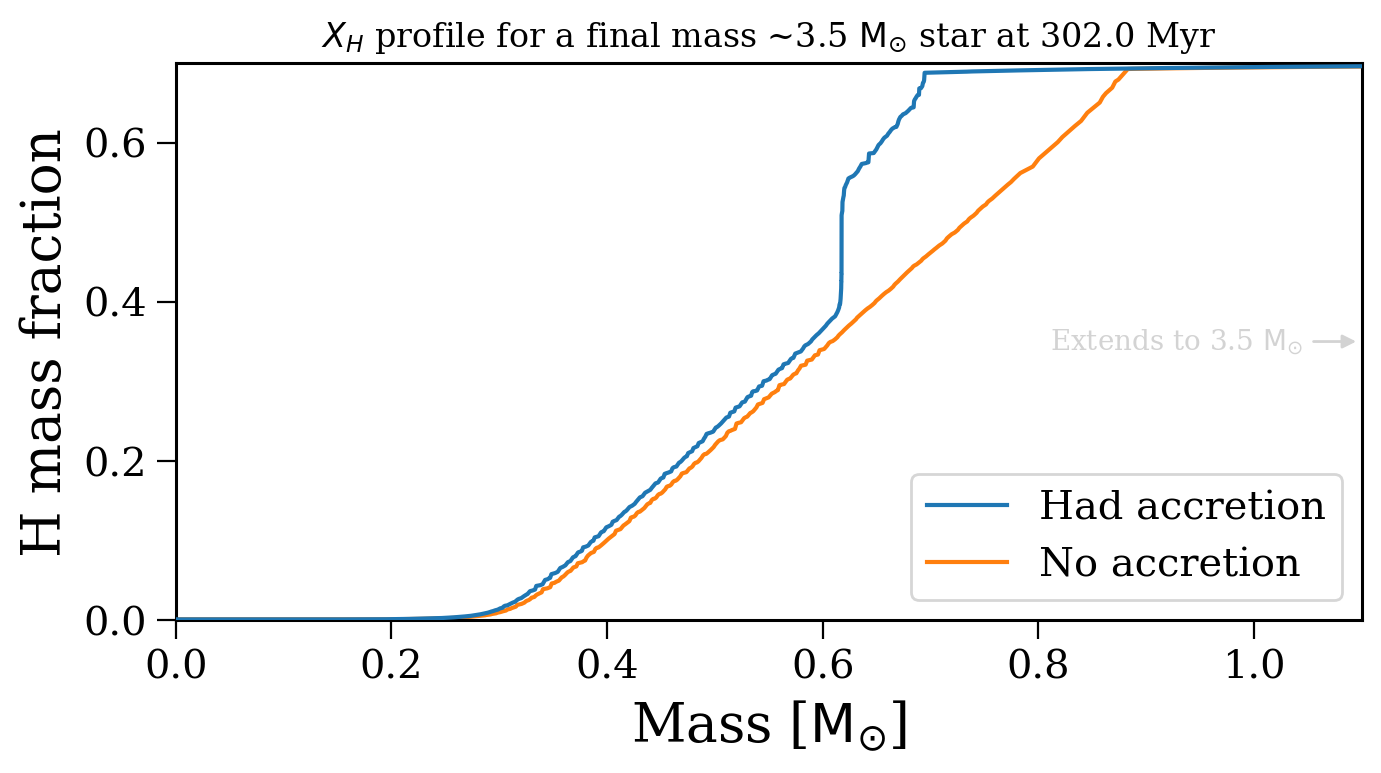

In [385]:
fig, ax = plt.subplots(figsize=(7, 4))
ani = FuncAnimation(fig, plot_X_H_profile,
                    get_timesteps(tracks[3], 10, 300, 5, 0.1, delay=15),
                    fargs=(3, 2, fig, ax, False), repeat=True)

writer = animation.PillowWriter(fps=5,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('X_H_profile_0.4.gif', writer=writer)

plt.show()

In [278]:
interact(plot_X_H_profile, age=IntSlider(150, 0, 224, continuous_update=False))

ValueError: None cannot be transformed to a widget

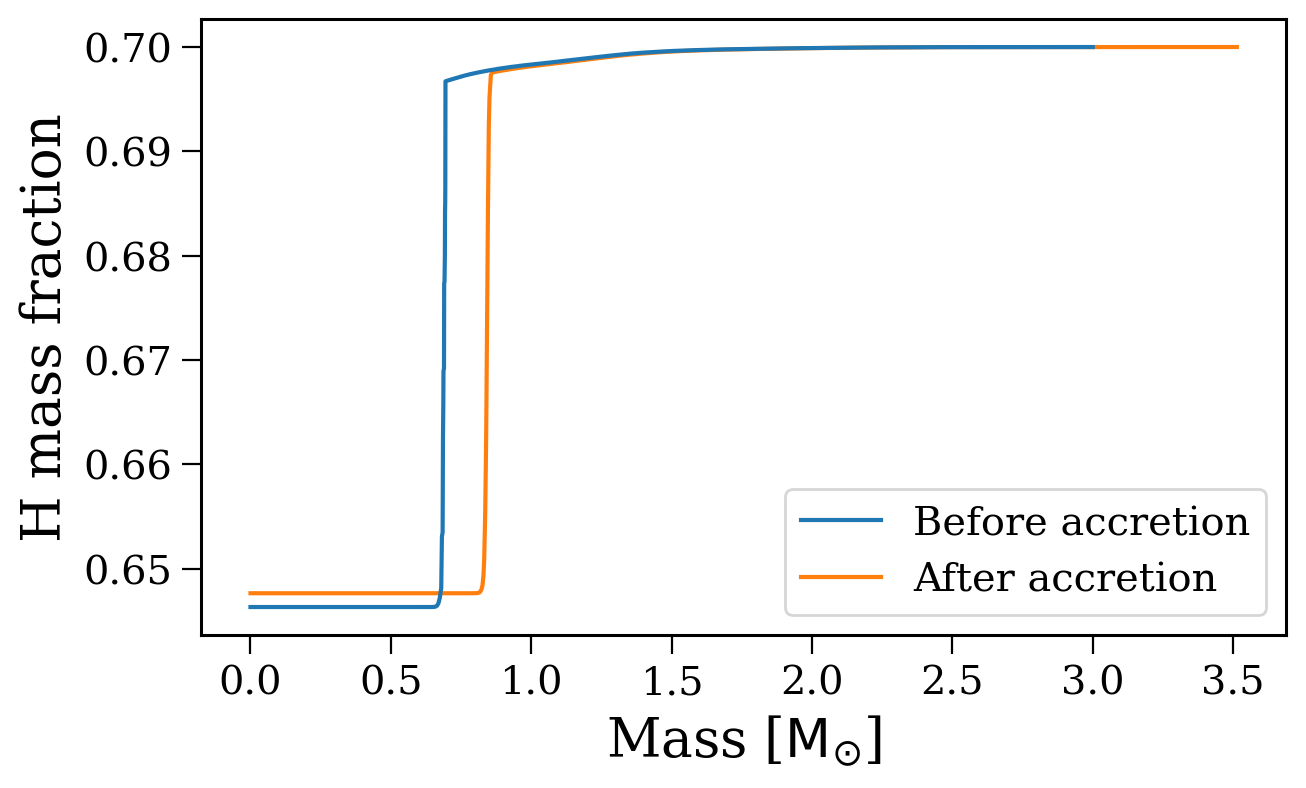

In [215]:
plt.figure(figsize=(7, 4))

plt.plot(tracks[1].profiles[40]["mass"], tracks[1].profiles[40]["x_mass_fraction_H"], label="Before accretion", zorder=3)
plt.plot(tracks[1].profiles[127]["mass"], tracks[1].profiles[127]["x_mass_fraction_H"], label="After accretion")

plt.legend()

plt.xlabel(r"Mass [$\rm M_{\odot}$]")
plt.ylabel("H mass fraction")

plt.show()

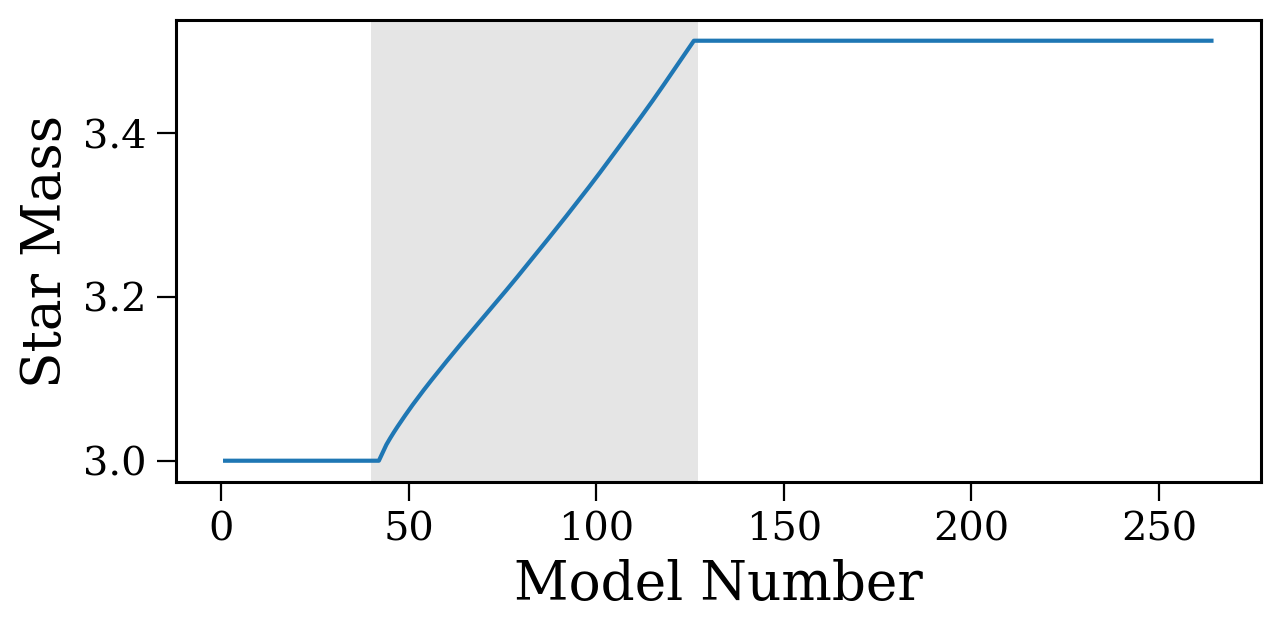

In [202]:
plt.figure(figsize=(7, 3))
plt.plot(tracks[1].history["model_number"], tracks[1].history["star_mass"])
plt.axvspan(40, 127, color="grey", alpha=0.2, lw=0)
plt.xlabel("Model Number")
plt.ylabel("Star Mass")
plt.show()